# PyTorch Mnist - Preprocessing & Analizing 

## 1. ETL - Extract, Load, Transform
* Extract - Get the Fashion Mnist images from the source
* Transform - Put the data into tensor form
* Load -  Put the data into an object to easaly use it  

### 1.1 Extract & Transform 

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn

# Datasets & transformations d’images 
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

transforms = transforms.Compose([transforms.ToTensor()])

train_data = FashionMNIST(root = './Data/FashionData', 
                          transform = transforms, 
                          train = True, 
                          download = True)

test_data = FashionMNIST(root = './Data/FashionData', 
                          transform = transforms, 
                          train = False, 
                          download = True)

dataloader = DataLoader(dataset = train_data, batch_size = 8, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = 8, shuffle = False)

### 1.2 Load

tensor([7, 3, 5, 0, 1, 6, 2, 3])


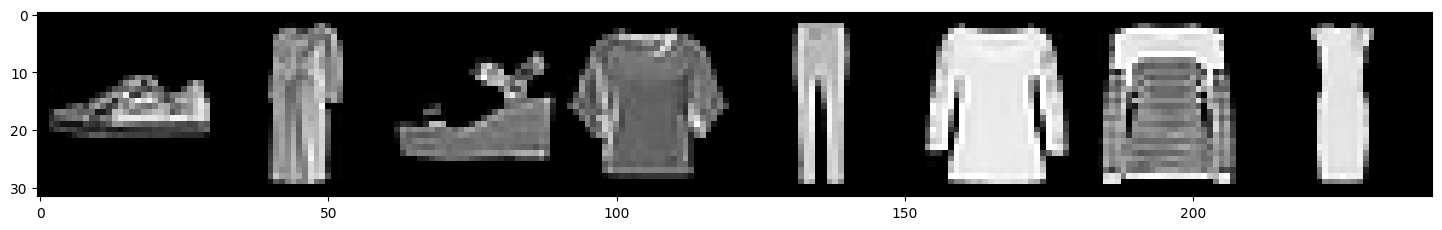

In [2]:
from torchvision.utils import make_grid

image, label = next(iter(dataloader))

grid = make_grid(image)
perm = torch.permute(input = grid, dims = (1, 2, 0))   # from torch.Size([3, 32, 242]) -> torch.Size([32, 242, 3]) 

print(label)
plt.figure(figsize = (18, 3))
plt.imshow(perm)
plt.show()

## 2. Create our Network Architecture

* `Conv2d`:
    * Takes a 1-channel (grayscale) image and applies 6 filters to produce 6 feature maps.
    * Each filter is a learnable kernel of size (3, 3).
    * In PyTorch: out_channels = number of filters (same as filters=6 in TensorFlow)
* `out_channels`:
    * Number of feature maps created by Conv2d = number of filters.
    * For example, out_channels=6 → 6 filters applied → 6 output maps (each filter create a new image).
* `Linear`:
    * Receives the flattened output of the last Conv2d layer.
    * We determine its input size (in_features) by printing the shape of the tensor after the conv layers.
* `out_features`:
    * Number of output neurons in the Linear (fully connected) layer.

In [3]:
import torch.nn.functional as F
from torchsummary import summary

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (3, 3))   # out_channels = num of filters = num of features map generated  
        self.relu1 = nn.ReLU()
        self.batchn = nn.BatchNorm2d(num_features = 6)
        self.dropout1 = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = (3, 3))  
        self.relu2 = nn.ReLU()
        self.batchn2 = nn.BatchNorm2d(num_features = 12)

        self.flatten = nn.Flatten()
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features = 12 * 24 * 24, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 60)
        self.fc3 = nn.Linear(in_features = 60, out_features = 10)    # 10 classes  (CrossEntropyLoss n’utilise pas Sigmoid, mais LogSoftmax + NLLLoss en interne.)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.batchn(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batchn2(x)
        x = self.flatten(x)
        x = self.dropout2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Network()
summary(net, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
           Dropout-4            [-1, 6, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             660
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Flatten-8                 [-1, 6912]               0
           Dropout-9                 [-1, 6912]               0
           Linear-10                  [-1, 120]         829,560
           Linear-11                   [-1, 60]           7,260
           Linear-12                   [-1, 10]             610
Total params: 838,186
Trainable params: 838,186
Non-trainable params: 0
-------------------------------

In [4]:
for name, param in net.named_parameters():
    print(name, '\t\t', param.shape)

conv1.weight 		 torch.Size([6, 1, 3, 3])
conv1.bias 		 torch.Size([6])
batchn.weight 		 torch.Size([6])
batchn.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 3, 3])
conv2.bias 		 torch.Size([12])
batchn2.weight 		 torch.Size([12])
batchn2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 6912])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([60, 120])
fc2.bias 		 torch.Size([60])
fc3.weight 		 torch.Size([10, 60])
fc3.bias 		 torch.Size([10])


### 2.1 Visualize Filters 

* `net.conv1.weight[0] ` : This shows the weights of the first filter in the first convolution layer (conv1) - torch.Size([6, 1, 3, 3]), conv2 - torch.Size([12, 6, 3, 3]).
    * Random at the beginning
    * Not trained yet
    * Ready to be changed during training

**What happens during training?**

Every time your model sees a batch of images:
* The filter goes over the image to look for patterns.
* The model makes a prediction.
* The prediction is compared to the correct answer using loss.
* Using backpropagation, the model changes the filter weights to make better predictions next time.



In [5]:
print('After the first Convolution: ')
print(net.conv1.weight.shape)  # We have 6 filters, 1 canal, and each filter is 3x3

weights_first_filter = net.conv1.weight[0]  # the weights of the first filter
weights_first_filter

After the first Convolution: 
torch.Size([6, 1, 3, 3])


tensor([[[ 0.2192,  0.0026,  0.1240],
         [-0.2762, -0.0867,  0.0286],
         [ 0.2012, -0.2278, -0.1412]]], grad_fn=<SelectBackward0>)

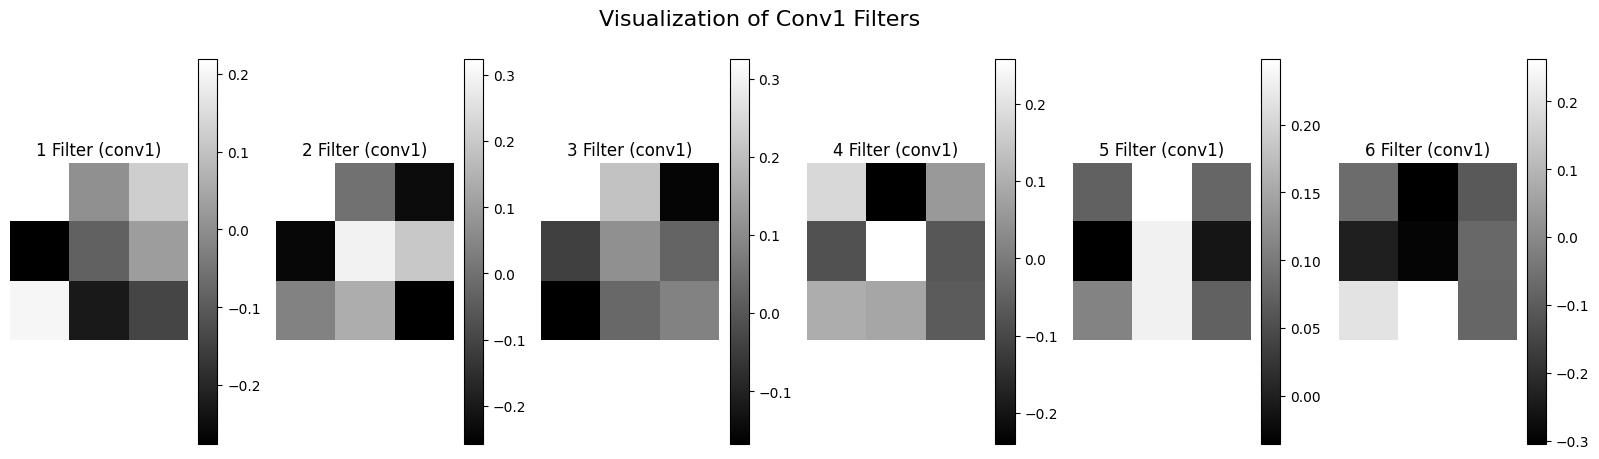

In [6]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (20, 5))

for i in range(6):
    each_filter = net.conv1.weight[i].squeeze().detach().numpy()
    im = axes[i].imshow(each_filter, cmap = 'gray')
    axes[i].set_title(f"{i + 1} Filter (conv1)")
    fig.colorbar(im, ax=axes[i])  
    axes[i].axis('off')

plt.suptitle("Visualization of Conv1 Filters", fontsize=16) 
plt.show()

### 2.2 Visualize Dense Layers

**Image :**
Each small image shows the weights of one neuron in the last layer (fc3). There are 10 neurons, one for each class (like digits 0 to 9).

Colors meaning:
* Red = positive weight
* Blue = negative weight
* White/gray = weight is close to 0

Each square is one connection to the previous layer (fc2).


**Exemple de lecture:**
Si dans FC3 N3, il y a :
* un grand carré bleu foncé au centre : → Cela signifie que ce neurone diminue sa sortie fortement quand ce poids est activé (inhibition).
* Un carré rouge foncé : → Cela renforce l’activation du neurone (donc favorise la prédiction de cette classe).

In [7]:
print('First Dense Layers')
print(net.fc1.weight.shape)
print('\nSecond Dense Layers')
print(net.fc2.weight.shape)
print('\nAfter Dot Product:')
print(torch.matmul(net.fc2.weight, net.fc1.weight).shape)

First Dense Layers
torch.Size([120, 6912])

Second Dense Layers
torch.Size([60, 120])

After Dot Product:
torch.Size([60, 6912])


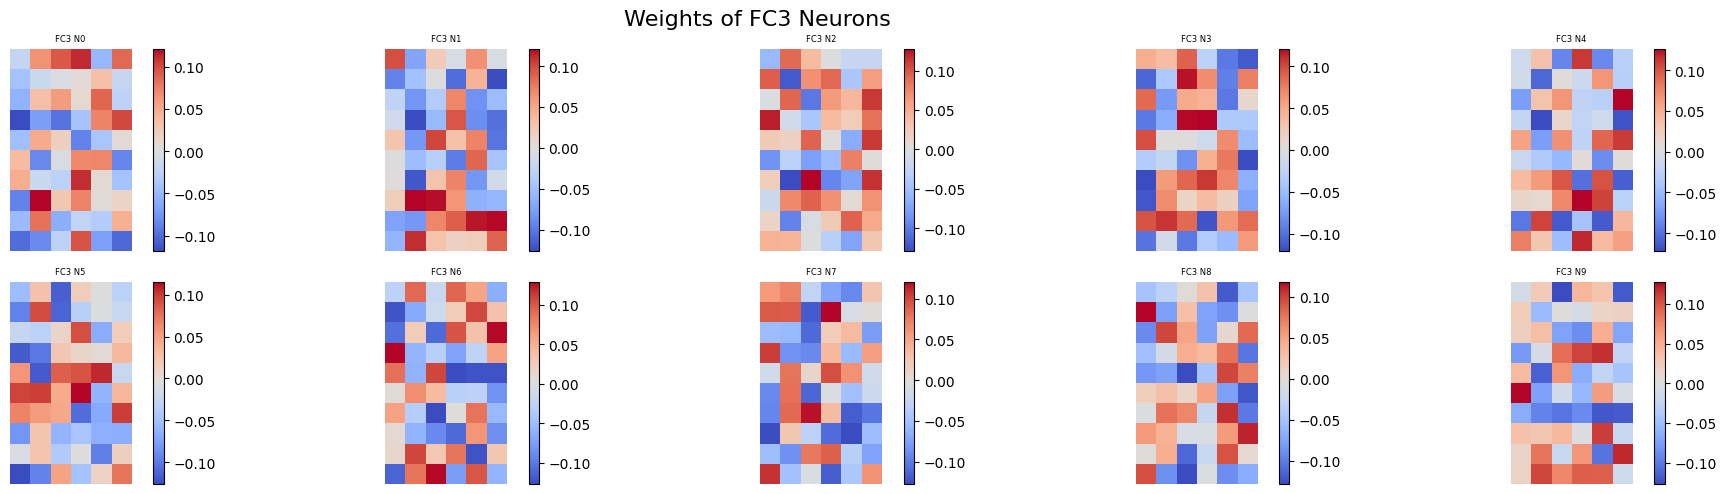

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(20, 5))  # 10 neurones
for i, ax in enumerate(axes.flat):
    weight = net.fc3.weight[i].detach().numpy()  # shape: (60,)
    im = ax.imshow(weight.reshape(10, 6), cmap = 'coolwarm')
    ax.set_title(f"FC3 N{i}", fontsize = 6)
    ax.axis('off')
    fig.colorbar(im, ax = ax)
fig.suptitle("Weights of FC3 Neurons", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## 3. Training

In [9]:
from torch.optim import Adam

# Classification multi-classes (≥2 classes), format entiers (long), Logits (pas de Softmax), Acc = argmax sur predictions
criterion = nn.CrossEntropyLoss()  
optimizer = Adam(net.parameters(), lr = 0.001)
EPOCHS = 10

lst_acc_train = []
lst_loss_train = []

lst_acc_test = []
lst_loss_test =[]

for epoch in range(EPOCHS):
    acc_train = 0
    loss_train = 0

    for data in dataloader:
        inputs, labels = data
        predictions = net(inputs)

        loss = criterion(predictions, labels.long())
        loss_train += loss.item()

        predicted_class = torch.argmax(predictions, dim = 1)
        acc = (predicted_class == labels).sum().item()
        acc_train += acc

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    with torch.no_grad():
        acc_test = 0
        loss_test = 0

        for data in test_dataloader:
            inputs, labels = data
            predictions = net(inputs)

            loss = criterion(predictions, labels.long())
            loss_test += loss.item()

            predicted_class = torch.argmax(predictions, dim=1)
            acc = (predicted_class == labels).sum().item()
            acc_test += acc


    lst_acc_train.append(acc_train / len(dataloader.dataset))
    lst_loss_train.append(loss_train / len(dataloader))

    lst_acc_test.append(acc_test / len(test_dataloader.dataset))
    lst_loss_test.append(loss_test / len(test_dataloader))

    print(f'Epoch: {epoch + 1}/{EPOCHS}')
    print(f'Train Loss: {lst_loss_train[-1]:.4f}')
    print(f'Test Loss: {lst_loss_test[-1]:.4f}')
    print(f'Train Accuracy: {lst_acc_train[-1]:.4f}')
    print(f'Test Accuracy: {lst_acc_test[-1]:.4f}')
    print('========================')

Epoch: 1/10
Train Loss: 0.5087
Test Loss: 0.4277
Train Accuracy: 0.8189
Test Accuracy: 0.8445
Epoch: 2/10
Train Loss: 0.3907
Test Loss: 0.3927
Train Accuracy: 0.8584
Test Accuracy: 0.8627
Epoch: 3/10
Train Loss: 0.3556
Test Loss: 0.3894
Train Accuracy: 0.8705
Test Accuracy: 0.8637
Epoch: 4/10
Train Loss: 0.3403
Test Loss: 0.3943
Train Accuracy: 0.8764
Test Accuracy: 0.8537
Epoch: 5/10
Train Loss: 0.3288
Test Loss: 0.3759
Train Accuracy: 0.8805
Test Accuracy: 0.8697
Epoch: 6/10
Train Loss: 0.3209
Test Loss: 0.3896
Train Accuracy: 0.8834
Test Accuracy: 0.8638
Epoch: 7/10
Train Loss: 0.3173
Test Loss: 0.3679
Train Accuracy: 0.8840
Test Accuracy: 0.8711
Epoch: 8/10
Train Loss: 0.3104
Test Loss: 0.3522
Train Accuracy: 0.8857
Test Accuracy: 0.8711
Epoch: 9/10
Train Loss: 0.3096
Test Loss: 0.3593
Train Accuracy: 0.8867
Test Accuracy: 0.8711
Epoch: 10/10
Train Loss: 0.3003
Test Loss: 0.3782
Train Accuracy: 0.8903
Test Accuracy: 0.8711


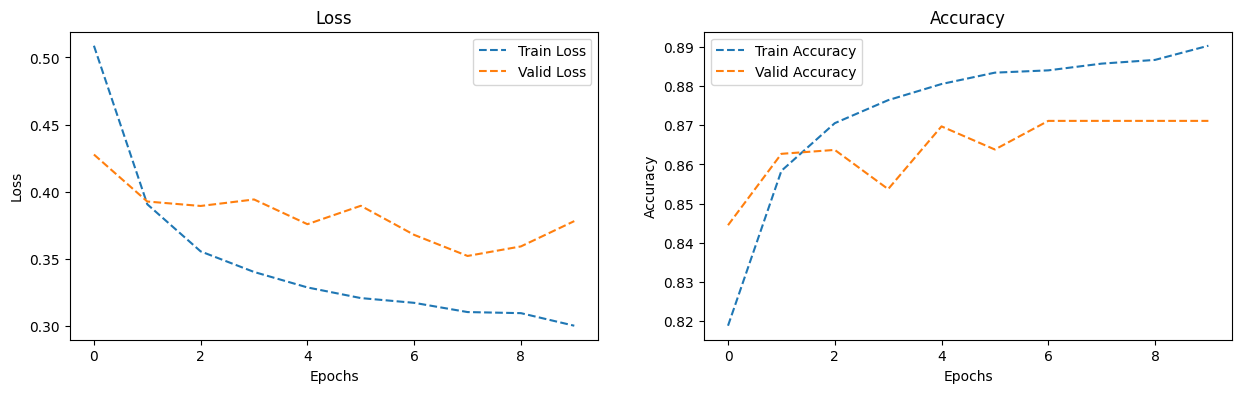

In [10]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(lst_loss_train, label='Train Loss', ls = '--')
plt.plot(lst_loss_test, label='Valid Loss', ls = '--')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(lst_acc_train, label='Train Accuracy', ls = '--')
plt.plot(lst_acc_test, label='Valid Accuracy', ls = '--')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()